In [56]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [57]:
import xarray as xr
import numpy as np
from xhistogram.xarray import histogram
from xmitgcm import open_mdsdataset

from sloped_MITgcm import *
from canyon_utils import *
from osse import *
from wmt import *

#### Constant parameters

In [58]:
# Constant parameters

Γ = 0.0008613659531090722
N = np.sqrt(g*α*Γ)
θ = 1.26E-3
f = -5.3e-5

h = 230
k0 = 5.2e-5
k1 = 1.8e-3

dx = 600.; dy = 600.
delta_t = 60.

In [59]:
nsnap = 24
dIter = 2*8640000//60

data_dir = f"../../MITgcm/experiments/rotated_BBTRE_idealized-plane/run_spinup/"

iters = np.arange(dIter, dIter+nsnap*dIter, dIter)
temp = open_mdsdataset(data_dir, iters=iters, ignore_unknown_vars=True,prefix=["standardDiag"], delta_t=delta_t)
temp = add_thalweg(temp)

extend_multiples = [-11, 5]
Lx = dx*temp.XC.size
temp_ex = periodic_extend(temp, ['XC', 'XG'], Lx, extend_multiples)
temp_ex, grid_ex = add_rotated_coords(temp_ex, θ)
temp_ex = add_background_temp(temp_ex, Γ)
temp_ex['θ'] = temp_ex['THETA_BG']

temp, grid = add_rotated_coords(temp, θ)
temp = add_background_temp(temp, Γ)
temp['time'] = temp['time'].astype(np.float64)*(1.e-9/86400.)
temp['dBdz'] = -g/ρ0*temp['DRHODR']+g*α*Γ
temp = temp.assign_coords({'Z_shift':temp.coords['Z']+3.0})
temp['dV'] = (temp.drF * temp.rA * temp.hFacC)
temp['θ'] = temp['THETA_BG']

/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.9/site-packages/xmitgcm/mds_store.py:178: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if iters == 'all':


# Normal domain

/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


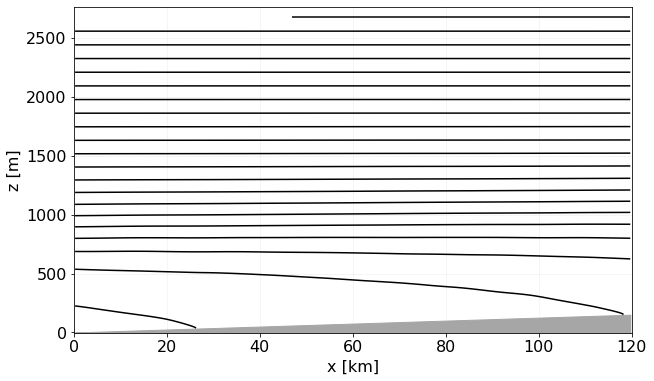

In [60]:
temp['θ'].isel(time=-1).mean('YC').plot.contour(colors="k", x="Xr", y="Zr", levels=np.arange(0., 3., 0.1))
plt.fill_between(temp["XC"], 0*temp["XC"], (temp.H - temp["Depthr"]).mean("YC"), color=nancol)
#plt.ylim(0, 1000)
xt, _ = plt.xticks()
plt.xticks(xt, np.int64(xt*1e-3))
plt.xlabel("x [km]")
plt.ylabel("z [m]")
plt.title("")
plt.grid(True, alpha=0.15)

# "Vertically"-stacked domain

In [61]:
ΔT = Γ*Lx*np.sin(θ)

/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


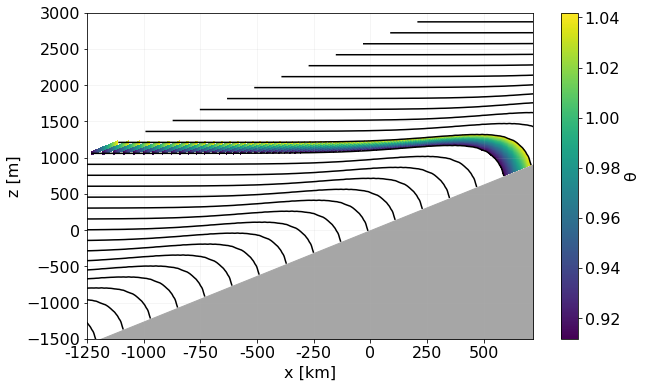

In [72]:
T0 = ΔT*7
T_class = temp_ex['θ'].where(np.logical_and(temp_ex['θ'] > T0, temp_ex['θ'] <= T0+ΔT))
T_class.isel(time=-1).mean('YC').plot.pcolormesh(x="Xr", y="Zr")
temp_ex['θ'].isel(time=-1).mean('YC').plot.contour(colors="k", x="Xr", y="Zr", levels=np.arange(-50*ΔT, 5., ΔT), linestyles="solid")
plt.fill_between(temp_ex["XC"], 0*temp_ex["XC"]-2000, (temp_ex.H - temp_ex["Depthr"]).mean("YC"), color=nancol)
plt.ylim(-1500, 3000)
xt, _ = plt.xticks()
plt.xticks(xt, np.int64(xt*1e-3))
plt.xlim(-1250e3, 720e3)
plt.xlabel("x [km]")
plt.ylabel("z [m]")
plt.title("")
plt.grid(True, alpha=0.15)

Text(0, 0.5, 'y [m]')

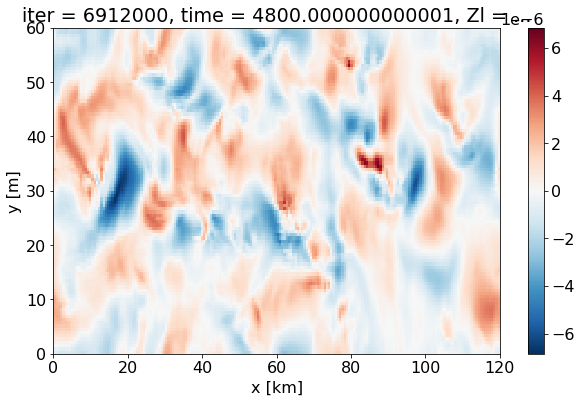

In [82]:
(temp['WVEL']*grid.interp(temp["THETA"], axis="Z", boundary='fill')).isel(time=-1, Zl=-20).plot()
xt, _ = plt.xticks()
plt.xticks(xt, np.int64(xt*1e-3))
yt, _ = plt.yticks()
plt.yticks(yt, np.int64(yt*1e-3))
plt.xlabel("x [km]")
plt.ylabel("y [m]")

/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


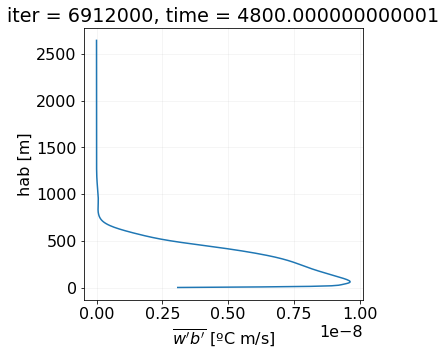

In [91]:
plt.figure(figsize=(5, 5))
(temp['WVEL']*grid.interp(temp["THETA"], axis="Z", boundary='fill')).isel(time=-1).mean(["XC", "YC"]).plot(y = "Zl")
plt.ylabel("hab [m]")
plt.xlabel(r"$\overline{w' b'}$ [ºC m/s]");
plt.grid(True, alpha=0.15)

In [6]:
Lx = dx*temp["XC"].size
Ly = dy*temp["YC"].size

In [7]:
Δz = 20.
Zr_levs = np.arange(-temp["Zr"].min()-Δz, 3000., Δz)

Zr, _ = xr.broadcast(temp["Zr"], temp["YC"])

A = histogram(
    Zr,
    bins=[Zr_levs],
    weights=temp["dV"],
    dim=('XC', 'YC', 'Z',)
).load()/Δz;

Afrac = A/(Lx*Ly)

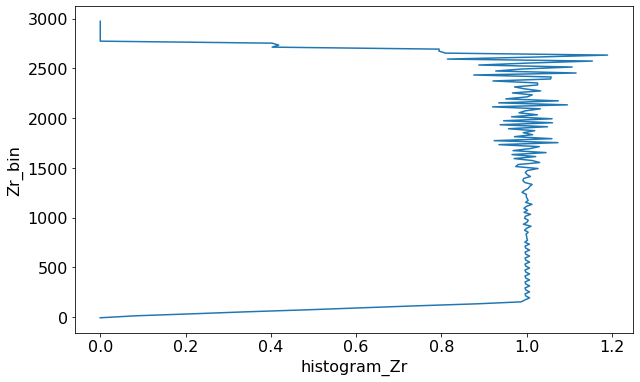

In [8]:
Afrac.plot(y="Zr_bin")

In [298]:
Zrmulti = Zr.stack(sort=("XC", "YC", "Z")).chunk({"sort": -1}).load()
Zrsort_index = xr.DataArray(np.arange(0, Zrmulti.size), coords=(Zrmulti["sort"],))
Zrmulti = Zrmulti.assign_coords({"sort_index": Zrsort_index})

In [299]:
Zrsorted = Zrmulti.sortby(Zrmulti).compute()

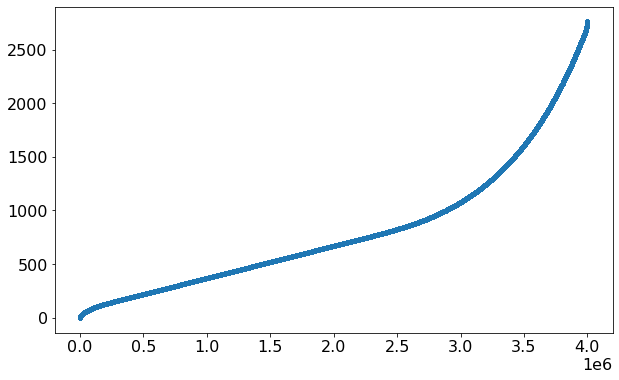

In [300]:
plt.plot(Zrsorted, ".")

In [323]:
# Interpolate A onto each grid cell (by interpolating A(Zr_bin) to A(Zrsorted))
# Asorted = A.interp(Zr_bin=Zrsorted)
# Aunsorted = Asorted.sortby(Asorted["sort_index"])

In [324]:
def adiabatic_sort_(da):
    return da.sortby(da)

def adiabatic_sort(da):
    # note: apply always moves core dimensions to the end
    return apply_ufunc(adiabatic_sort_, da,
                       input_core_dims=[["time"]],
                       kwargs={'axis': -1})

In [325]:
θmulti = temp['θ'].isel(time=-1).stack(sort=("XC", "YC", "Z")).chunk({"sort": -1}).load()
sort_index = xr.DataArray(np.arange(0, θmulti.size), coords=(θmulti["sort"],))
θmulti = θmulti.assign_coords({"sort_index": sort_index})

In [326]:
θsorted = θmulti.sortby(θmulti).compute()

In [327]:
dV_multi = temp['dV'].stack(sort=("XC", "YC", "Z")).chunk({"sort": -1}).load()

In [350]:
N = dV_multi.size
dzstar = np.zeros(N)
zstar = np.zeros(N)
for e in range(1, N):
    if (e%1e4)==0: print(f"{int(e//1e4)}/{int(N//1e4)}", end=", ")
    dzstar[e] = dV_multi[e]/A.interp(Zr_bin=zstar[e-1])
    zstar[e] = zstar[e-1]+dzstar[e]

1/400, 2/400, 3/400, 4/400, 5/400, 6/400, 7/400, 8/400, 9/400, 10/400, 11/400, 12/400, 13/400, 14/400, 15/400, 16/400, 17/400, 18/400, 19/400, 20/400, 21/400, 22/400, 23/400, 24/400, 25/400, 26/400, 27/400, 28/400, 29/400, 30/400, 31/400, 32/400, 33/400, 34/400, 35/400, 36/400, 37/400, 38/400, 39/400, 40/400, 41/400, 42/400, 43/400, 44/400, 45/400, 46/400, 47/400, 48/400, 49/400, 50/400, 51/400, 52/400, 53/400, 54/400, 55/400, 56/400, 57/400, 58/400, 59/400, 60/400, 61/400, 62/400, 63/400, 64/400, 65/400, 66/400, 67/400, 68/400, 69/400, 70/400, 71/400, 72/400, 73/400, 74/400, 75/400, 76/400, 77/400, 78/400, 79/400, 80/400, 81/400, 82/400, 83/400, 84/400, 85/400, 86/400, 87/400, 88/400, 89/400, 90/400, 91/400, 92/400, 93/400, 94/400, 95/400, 96/400, 97/400, 98/400, 99/400, 100/400, 101/400, 102/400, 103/400, 104/400, 105/400, 106/400, 107/400, 108/400, 109/400, 110/400, 111/400, 112/400, 113/400, 114/400, 115/400, 116/400, 117/400, 118/400, 119/400, 120/400, 121/400, 122/400, 123/400, 1

/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/xarray/core/missing.py:556: RuntimeWarning: All-NaN slice encountered
  minval = np.nanmin(new_x.values)
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/xarray/core/missing.py:557: RuntimeWarning: All-NaN slice encountered
  maxval = np.nanmax(new_x.values)


KeyError: nan

In [351]:
# dzstar_multi = (dV_multi/Aunsorted).compute()
# dzstar_sorted = dzstar_multi.sortby(θmulti).compute()

In [352]:
# Interpolate A onto each zref level
#Aref = A.interp(Zr_bin=zref)
#dzstar_sorted = (dV_multi.sortby(θmulti)/Aref).compute()

In [353]:
θref = θsorted
zref = np.copy(zstar)

(0.0, 0.1)

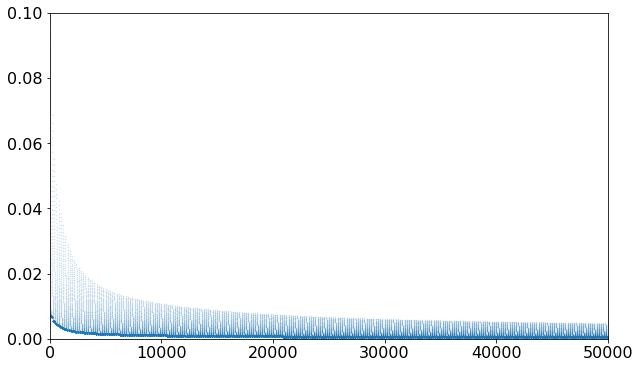

In [372]:
plt.plot(dzstar, ".", markersize=1., alpha=0.2)
plt.xlim(0, 5e4)
plt.ylim(0, 0.1)

(0.0, 100.0)

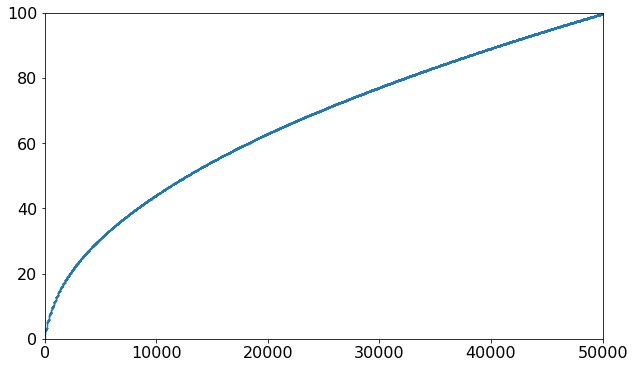

In [356]:
plt.plot(zref, ".", markersize=1., alpha=0.2)
plt.xlim(0, 5e4)
plt.ylim(0, 100)

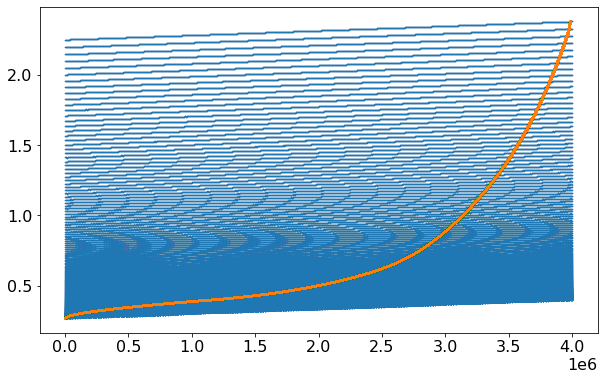

In [313]:
plt.plot(θmulti, ".", markersize=0.5, alpha=0.2)
plt.plot(θsorted, ".", markersize=1., alpha=0.9)

In [357]:
zr = Zr.stack(sort=("XC", "YC", "Z")).chunk({"sort": -1}).load().sortby(θmulti).compute()

In [358]:
dv = temp["dV"].stack(sort=("XC", "YC", "Z")).chunk({"sort": -1}).load().sortby(θmulti).compute()

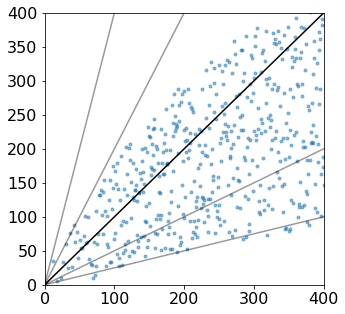

In [359]:
plt.figure(figsize=(5,5))
plt.plot(zref[::1000], zr[::1000], ".", alpha=0.5)
plt.xlim(0, 400)
plt.ylim(0, 400)
plt.plot([0, 900], [0, 900], "k-")
plt.plot([0, 900], [0, 900/2], "k-", alpha=0.4)
plt.plot([0, 900], [0, 900*2], "k-", alpha=0.4)
plt.plot([0, 900], [0, 900/4], "k-", alpha=0.4)
plt.plot([0, 900], [0, 900*4], "k-", alpha=0.4)

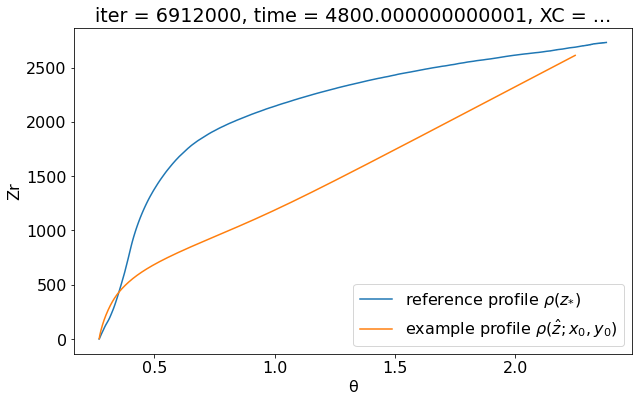

In [373]:
plt.plot(θref, zref, label=r"reference profile $\rho(z_{*})$")
temp['θ'].isel(time=-1, YC=50, XC=0).plot(y="Zr", label=r"example profile $\rho(\hat{z}; x_{0}, y_{0})$")
plt.legend()

In [363]:
θref_low = θref.sel(sort=θref["sort"][::10000])

In [365]:
zref

array([0.        , 0.09710391, 0.19015488, ..., 0.        , 0.        ,
       0.        ])

In [366]:
zref_low = zref[::10000]

In [368]:
θref_2d, _ = xr.broadcast(θref_low, temp["XC"].rename({"XC": "X"}))
zref_2d, _ = np.meshgrid(zref_low, temp["XC"].rename({"XC": "X"}).values)

/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


(0.0, 200.0)

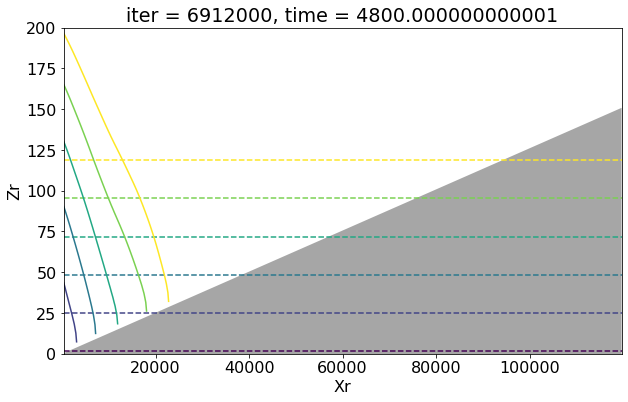

In [369]:
plot_levs = np.arange(0.27, 0.3, 0.005)
#plot_levs = [0.278]
plt.contour(θref_2d["X"], zref_low, θref_2d, levels=plot_levs, linestyles="dashed")
temp['θ'].isel(time=-1).mean("YC").plot.contour(x="Xr", y="Zr", levels=plot_levs)
plt.fill_between(temp['XC'], temp["XC"]*0-temp.H, temp.H - temp["Depthr"].mean("YC"), facecolor=nancol)
plt.ylim(0, 200)
#plt.xlim(0, 10000)

#### Available potential energy

$E_{a} \equiv g \int (z - z_{*}) \rho \text{d}V$

In [101]:
Ea = (g*(zr - zref)*θref*dv).sum(skipna=True)

In [102]:
Ep = (g*zr*θref*dv).sum(skipna=True)

In [107]:
Ea, Ep

(<xarray.DataArray ()>
 array(1.45990921e+15)
 Coordinates:
     iter     int64 6912000
     time     float64 4.8e+03,
 <xarray.DataArray ()>
 array(4.0469712e+17)
 Coordinates:
     iter     int64 6912000
     time     float64 4.8e+03)

In [1]:
temp["Zr"]

NameError: name 'temp' is not defined